## Neuroevolution using EvoTorch

#### Imports

In [1]:
import torch
import numpy as np
import math

from evotorch.tools import dtype_of, device_of
from evotorch.neuroevolution import NEProblem
from evotorch.algorithms import PGPE, SNES
from evotorch.logging import PandasLogger, StdOutLogger

from Trainer import Trainer
from Model import Complex_CA
from State_Generator import Generator, State

In [2]:
#hw = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
#hw = 'cuda'
hw = 'cpu'
device = torch.device(hw)
batch_size = 16
generator = Generator(False)
device

device(type='cpu')

#### Helper functions

In [3]:
batch = generator.generate_ca_and_food(batch_size)

In [4]:
def average_placement(x):
    #TODO what happens in case the total value of the CA is negative? - Only the case when the model sucks but still the case
    size = x.shape[0]
    d1 = 0
    d2 = 0
    total = x.sum() / size
    if total <= 0:
        return(17, 17)
    
    def to_int(x):
        if math.isnan(x):
            return 0
        else:
            return int(x)

    for i in range(size):
        d1 += x[i].mean() * i / total
        d2 += x[:, i].mean() * i / total
    return (to_int(d1), to_int(d2))

#### Network

In [5]:
#TODO load one of the good existing models and train from here?

#### Actor - For sharing batch between all rays

In [6]:
import ray

@ray.remote
class GlobalVarActor:
    def __init__(self):
        self.batch = generator.generate_ca_and_food(batch_size)
        self.time_steps = np.random.randint(25,45)

    def set_global_var(self):
        self.batch = generator.generate_ca_and_food(batch_size)
        self.time_steps = np.random.randint(25,45)

    def get_global_var(self):
        return (self.batch, self.time_steps)

global_var = GlobalVarActor.remote()
ray.get(global_var.set_global_var.remote())
print(ray.get(global_var.get_global_var.remote())[0].sum())

2022-12-05 16:47:29,261	INFO worker.py:1528 -- Started a local Ray instance.


224.0


#### Fitness function

In [7]:
#test
batch = generator.generate_ca_and_food(batch_size)
batch = torch.tensor(batch, device=device)
cell = batch
food = batch[:, 3]
#food_pos = np.apply_along_axis(average_placement, 1, food)
food_pos = np.ones(shape=(17,2))
average_cell_pos = np.ones(shape=(17,2))
for i, x in enumerate(food):
    food_pos[i] = average_placement(x)
for i, x in enumerate(cell[:, 0]):
    average_cell_pos[i] = average_placement(x)
distance = ((food_pos - average_cell_pos) ** 2).sum()
print(distance)

1789.0


In [8]:
class Custom_NE(NEProblem):
    #def __init__(self, objective_sense, network, network_args, device, num_actors, searcher):
    #    super(Custom_NE, self).__init__(objective_sense=objective_sense, network=network, network_args=network_args, device=device, num_actors=num_actors)

    def _evaluate_network(self, network: torch.nn.Module):
        #We need some way of ensuring each new batch is the same for each network in the same generation - otherwise we optimize on luck rather than skill
        (batch, steps) = ray.get(global_var.get_global_var.remote())
        #batch = generator.generate_ca_and_food(batch_size)
        cell = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
        cell = cell
        food = cell[:, 3].clone() #Clone is Necessary as the cell actually changes during training 

        total_pixel_val_before = network.total_pixel_val(cell[:, 0:1])    
        living_count_before = network.living_cells_above(cell[:, 0:1], 0.1)
        food_pos = np.ones(shape=(17,2))
        for i, x in enumerate(food):
            food_pos[i] = average_placement(x)
        #print(food_pos[0])

        #steps = 35

        #apply model
        #TODO find some way of allowing cell can consume food - set some constraints like 4 nearby cells with value above x
        with torch.no_grad():
            cell, food, total_pixel_val, living_count = network(cell, food, steps)
        
        total_pixel_diff = ((total_pixel_val_before - total_pixel_val) ** 2).sum()
        living_count_diff = ((living_count_before - living_count) ** 2).sum()
        average_cell_pos = np.ones(shape=(17,2))
        for i, x in enumerate(cell[:, 0]):
            average_cell_pos[i] = average_placement(x)
        distance = ((food_pos-average_cell_pos) ** 2).sum()

        #print('pixel before: %0.3f, living before: %0.3f, food pos: (%d, %d)' % (total_pixel_val_before[0], living_count_before[0], food_pos[0, 0], food_pos[0, 1]))
        #print('pixel after: %0.3f, living after: %0.3f, ca pos: (%d, %d)' % (total_pixel_val[0], living_count[0], average_cell_pos[0,0], average_cell_pos[0, 1]))
        #print('pixel diff: %0.3f, living diff: %0.3f, distance diff: %0.3f' % (total_pixel_diff, living_count_diff, distance))

        fitness = total_pixel_diff + living_count_diff + distance*10
        return fitness

#### Creating problem

In [9]:
problem = Custom_NE(
    objective_sense="min",
    network=Complex_CA,
    network_args={"device":device, "batch_size":batch_size},
    #network_eval_func=score,
    #device="cpu",
    device=hw,
    num_actors='max',
)

/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Searcher algorithm

In [10]:
#class Custom_Searcher(PGPE):
#    def __init__(self, problem, *, popsize, center_learning_rate, stdev_learning_rate, stdev_init=None, radius_init=None, num_interactions=None, popsize_max=None, optimizer='clipup', optimizer_config=None, ranking_method='centered', center_init=None, stdev_min=None, stdev_max=None, stdev_max_change=0.2, symmetric=True, obj_index=None, distributed=False, popsize_weighted_grad_avg=None):
#        super(Custom_Searcher, self).__init__(problem, popsize=popsize, center_learning_rate=center_learning_rate, stdev_learning_rate=stdev_learning_rate, stdev_init=stdev_init, radius_init=radius_init, num_interactions=num_interactions, popsize_max=popsize_max, optimizer=optimizer, optimizer_config=optimizer_config, ranking_method=ranking_method, center_init=center_init, stdev_min=stdev_min, stdev_max=stdev_max, stdev_max_change=stdev_max_change, symmetric=symmetric, obj_index=obj_index, distributed=distributed, popsize_weighted_grad_avg=popsize_weighted_grad_avg)
class Custom_Searcher(SNES):
    def __init__(self, problem, radius_init):
        super(Custom_Searcher, self).__init__(problem, radius_init=radius_init)
    
    def before(self):
        #print(self.step_count)
        ray.get(global_var.set_global_var.remote())

    def after(self):
        if(self.step_count % 100 == 99):
            #save model
            trained_network = problem.parameterize_net(self.status['center'])
            torch.save(trained_network.state_dict(), 'models/evo_temp.pth')

In [11]:
searcher = Custom_Searcher(
    problem,
    radius_init=2.5,
)

searcher.before_step_hook.append(searcher.before)

#### Logger and run

In [12]:
logger = StdOutLogger(searcher)
logger = PandasLogger(searcher)
searcher.run(500)

(EvaluationActor pid=44910) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
(EvaluationActor pid=44910)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
(EvaluationActor pid=44913) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
(EvaluationActor pid=44913)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
(EvaluationActor pid=44912) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWar

         iter : 1
    mean_eval : 27618.681640625
  median_eval : 29318.0
pop_best_eval : 23910.0
    best_eval : 23910.0
   worst_eval : 30381.765625

         iter : 2
    mean_eval : 24646.5625
  median_eval : 21336.06640625
pop_best_eval : 20142.400390625
    best_eval : 20142.400390625
   worst_eval : 49754.8828125

         iter : 3
    mean_eval : 16832.134765625
  median_eval : 15640.0
pop_best_eval : 14920.025390625
    best_eval : 14920.025390625
   worst_eval : 49754.8828125

         iter : 4
    mean_eval : 20079.12890625
  median_eval : 19150.0
pop_best_eval : 19150.0
    best_eval : 14920.025390625
   worst_eval : 49754.8828125

         iter : 5
    mean_eval : 12700.8515625
  median_eval : 12630.0
pop_best_eval : 12630.0
    best_eval : 12630.0
   worst_eval : 49754.8828125

         iter : 6
    mean_eval : 19535.142578125
  median_eval : 16336.0
pop_best_eval : 16310.0
    best_eval : 12630.0
   worst_eval : 58768.0

         iter : 7
    mean_eval : 22278.056640625


#### Show learning curve

<AxesSubplot:xlabel='iter'>

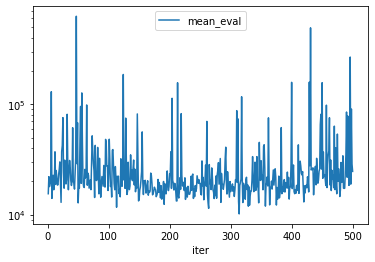

In [ ]:
#TODO find a way of showing this in logarithmic scale
#logger.to_dataframe().mean_eval.plot(Log=True)
#logger.to_dataframe().mean_eval.plot()
#x = logger.to_dataframe().mean_eval
#logger.to_dataframe().mean_eval.plot(log=True)


logger.to_dataframe().plot(y='mean_eval', logy=True)
#logger.to_dataframe().plot(y='mean_eval')

<AxesSubplot:xlabel='iter'>

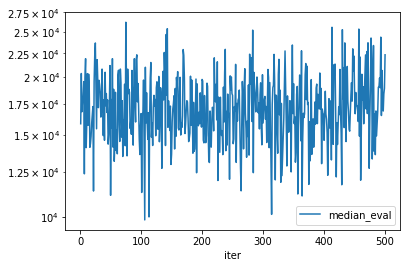

In [ ]:
logger.to_dataframe().plot(y='median_eval', logy=True)

#### Get Network with parameters according to trained model

In [ ]:
searcher.status

<LazyStatusDict
    center = tensor([ 0.91,  0.28, -0.04,  ...,  0.19,  0.28, -0.95])
    stdev = tensor([0.07, 0.08, 0.09,  ..., 0.06, 0.06, 0.07])
    mean_eval = 24674.234375
    pop_best_eval = 18031.7109375
    pop_best = <Solution values=tensor([ 1.00,  0.27, -0.19,  ...,  0.19,  0.24, -0.90]), evals=tensor([18031.71])>
    median_eval = 22304.0
    iter = 500
    best = <Solution values=tensor([ 0.12, -0.11,  0.16,  ..., -0.00,  0.26,  0.03]), evals=tensor([4935.30])>
    worst = <Solution values=tensor([-0.04, -0.05,  0.11,  ..., -0.09,  0.15, -0.10]), evals=tensor([14629576.])>
    best_eval = 4935.2998046875
    worst_eval = 14629576.0
>

In [ ]:
trained_network = problem.parameterize_net(searcher.status['center'])
#save model
torch.save(trained_network.state_dict(), 'models/evo5.pth')

In [ ]:
#trained_network = problem.parameterize_net(searcher.status['best'])
#torch.save(trained_network.state_dict(), 'models/evo5_best.pth')

In [ ]:
#trained_network.load_state_dict(torch.load('models/evo5_best.pth'))

#### Use Model

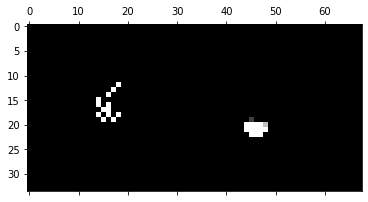

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import IPython

#TODO
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    return row1

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    mat.set_data(extract_data(cell, target)) 
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))


cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

mat = ax.matshow(extract_data(cell, target), cmap='gray')

def init_animate():
    mat.set_data(extract_data(cell, target)) 
    #ax.matshow(extract_data(cell, target), cmap='gray')

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, init_func=init_animate, frames=50, interval=150).to_jshtml())
#video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=150).to_jshtml())
video

In [ ]:
network = trained_network
#state = generator.generate_moving_state(50, batch_size)
batch = generator.generate_ca_and_food(batch_size)
#cell = torch.tensor(state.x, dtype=dtype_of(trained_network), device=device)
#food = torch.tensor(state.food, dtype=dtype_of(trained_network), device=device)

cell = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
food = torch.tensor(batch[:, 3], dtype=dtype_of(network), device=device_of(network))

#print(food1 == food)

#target = state.x[:, 0]
#food_coord = generator.get_food_coord_from_food(state.food)

tensor(208., grad_fn=<SumBackward0>)


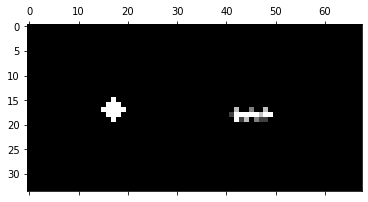

In [ ]:
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')
#cell, target, i = animate2(i, cell, target, food)
cell, _, _, _= trained_network(cell, food, 1)
target = generator.move_towards_food(target, food_coord)
print(cell[:, 0].sum())